In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as data

from model import ResidualBlock, ResNet
from train_eval_util import train, evaluate, calculate_accuracy, epoch_time, total_params, total_layers, get_predictions, plot_confusion_matrix
from dataset import train_data, valid_data, test_data

import time
import numpy as np 
import matplotlib.pyplot as plt

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')  
else:
    device = torch.device('cpu')

print(f"Selected device: {device}")

Selected device: mps


In [3]:
BATCH_SIZE = 32

train_iterator = DataLoader(train_data, batch_size= BATCH_SIZE, shuffle=True)
valid_iterator =  DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False)
test_iterator =  DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [4]:
model = ResNet(ResidualBlock, [1, 1, 1]).to(device)

print(f"Total number of layers: {total_layers(model)}")
print(f"Total number of parameters: {total_params(model)}")

from torchsummary import summary
# summary(model)

Total number of layers: 8
Total number of parameters: 78042


In [5]:
num_epochs = 5
train_acc_history = []
train_loss_history = []
valid_acc_history = []
valid_loss_history = []
lr_epoch = []

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay = 0.0001)
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

for epoch in range(num_epochs):

    start_time = time.time()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    
    scheduler.step()
    lr_now = lr_now = optimizer.param_groups[0]['lr']
    lr_epoch.append(lr_now)

    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
        
    end_time = time.time()

        
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | LR: {lr_now:.6f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    

    train_acc_history.append(train_acc)
    train_loss_history.append( train_loss)
    valid_acc_history.append(valid_acc)
    valid_loss_history.append(valid_loss)

Epoch: 01 | Epoch Time: 0m 36s
	Train Loss: 1.453 | Train Acc: 47.06% | LR: 0.000905
	 Val. Loss: 1.191 |  Val. Acc: 56.21%
Epoch: 02 | Epoch Time: 0m 34s
	Train Loss: 1.079 | Train Acc: 61.56% | LR: 0.000655
	 Val. Loss: 1.076 |  Val. Acc: 61.15%
Epoch: 03 | Epoch Time: 0m 33s
	Train Loss: 0.932 | Train Acc: 66.97% | LR: 0.000345
	 Val. Loss: 0.863 |  Val. Acc: 69.41%
Epoch: 04 | Epoch Time: 0m 33s
	Train Loss: 0.836 | Train Acc: 70.62% | LR: 0.000095
	 Val. Loss: 0.800 |  Val. Acc: 71.52%
Epoch: 05 | Epoch Time: 0m 33s
	Train Loss: 0.777 | Train Acc: 73.03% | LR: 0.000000
	 Val. Loss: 0.746 |  Val. Acc: 72.81%


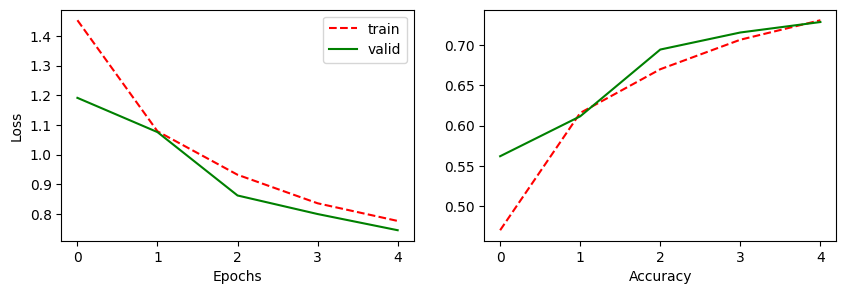

In [6]:
fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

ax1.plot(range(num_epochs), train_loss_history, '--r')
ax1.plot(range(num_epochs), valid_loss_history, '-g')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend(['train', 'valid'])

ax2.plot(range(num_epochs), train_acc_history, '--r')
ax2.plot(range(num_epochs), valid_acc_history, '-g')
ax2.set_xlabel('Epochs')
ax2.set_xlabel('Accuracy')
ax1.legend(['train', 'valid'])

In [7]:
# torch.save(model, 'model.pth')

In [8]:
import numpy as np 

np.save( 'history/train_acc_history.npy', train_acc_history)
np.save('history/train_loss_history.npy', train_loss_history )
np.save('history/valid_acc_history.npy', valid_acc_history )
np.save('historyvalid_loss_history.npy', valid_loss_history)
np.save('history/lr_per_epoch.npy', lr_epoch, )

In [9]:
# final_model = torch.load('model.pt')
test_loss, test_accurcy = evaluate(model, test_iterator, criterion, device)
print(f'test loss: {test_loss}, validation: {test_accurcy}')

test loss: 0.7449818874319522, validation: 0.735223642172524


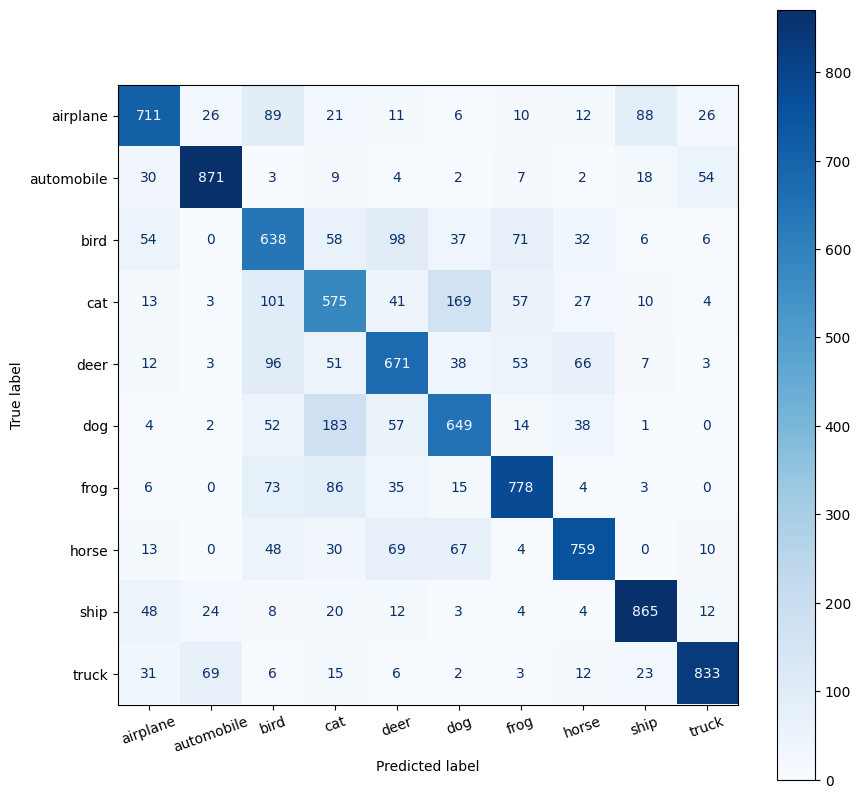

In [22]:
classes = test_data.classes
labels, probs = get_predictions(model.cpu(), test_iterator, torch.device('cpu'))
pred_labels = torch.argmax(probs, 1)
# pred_labels.cpu()
plot_confusion_matrix(labels, pred_labels, classes) 
